In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
import pennylane as qml
import tensorflow as tf
from tensorflow import keras as K
from timeit import default_timer as timer
from datetime import timedelta
from os import listdir
import os
from matplotlib import image
import h5py
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import itertools
from pennylane import numpy as np

In [2]:
def cargar_dataset(csv_file, metricas):
    signals = []
    labels = []

    # Leer el archivo JSON como un DataFrame
    with open(metricas, 'r') as f:
        data = json.load(f)

    # Obtener los valores de las variables del DataFrame
    db_mean = data['mean']
    db_std = data['std']
    db_min = data['min']
    db_max = data['max']

    datos=pd.read_csv(csv_file)

    
    for i in range(len(datos)):
        signals.append(np.array(json.loads(datos.iloc[i, 0]), dtype=float)- db_min / (db_max - db_min))
        labels.append(datos.iloc[i, 1])
        
    return signals, labels

In [3]:
signals, labels = cargar_dataset('data/datos.csv', 'data/variables.json')

In [4]:
train_signals, test_signals, train_labels, test_labels = train_test_split(
    signals, labels, test_size=0.3
)

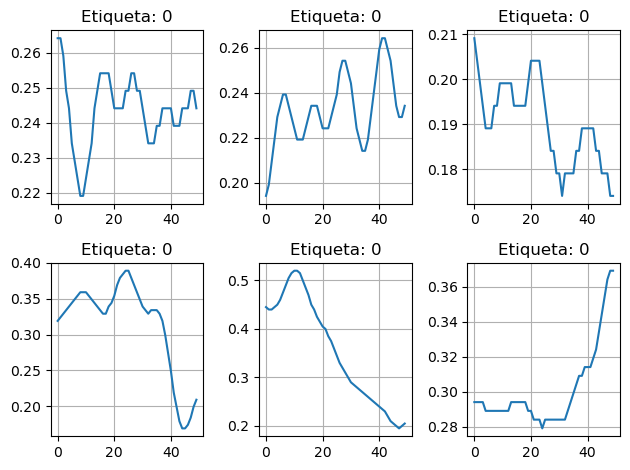

In [5]:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.grid()
    plt.title("Etiqueta: {}".format(train_labels[i]))
    plt.plot(train_signals[i])
    #plt.plot(train_signals[i])
plt.tight_layout()

In [6]:
wires=5

dev4 = qml.device("default.qubit", wires=wires)  # define the simulator
@qml.qnode(dev4)
def CONVCircuit(phi, wires, i=0):
    """
    quantum convolution Node
    """
    # parameter
    theta = np.pi / 2

    qml.RX(phi[0] * np.pi, wires=0)
    qml.RX(phi[1] * np.pi, wires=1)
    qml.RX(phi[2] * np.pi, wires=2)
    qml.RX(phi[3] * np.pi, wires=3)
    qml.RX(phi[4] * np.pi, wires=4)

    qml.CRZ(theta, wires=[1, 0])
    qml.CRZ(theta, wires=[4, 3])
    qml.CRX(theta, wires=[1, 0])
    qml.CRX(theta, wires=[4, 3])
    
    qml.CRZ(theta, wires=[0, 2])
    qml.CRX(theta, wires=[0, 2])
    qml.CRZ(theta, wires=[3, 2])
    qml.CRX(theta, wires=[3, 2])

    # Expectation value
    measurement = qml.expval(qml.PauliZ(wires=2))

    return measurement


def QCONV1(X, step=1):
    """
    quantum convolutional layer
    """

    #H, W, CH = X.shape
    l=len(X)
    out = np.zeros(l-5)
    #progress = 0
    for i in range(l-5):
        phi=X[i:i+5]
        measurement = CONVCircuit(phi, len(phi))
        out[i]=measurement
        
    return out

In [7]:
phi = [1, 1, 1, 1, 1]
drawer = qml.draw(CONVCircuit)
print(drawer(phi, 5))

0: ──RX(3.14)─╭RZ(1.57)─╭RX(1.57)─╭●────────╭●────────────────────────────┤     
1: ──RX(3.14)─╰●────────╰●────────│─────────│─────────────────────────────┤     
2: ──RX(3.14)─────────────────────╰RZ(1.57)─╰RX(1.57)─╭RZ(1.57)─╭RX(1.57)─┤  <Z>
3: ──RX(3.14)─╭RZ(1.57)─╭RX(1.57)─────────────────────╰●────────╰●────────┤     
4: ──RX(3.14)─╰●────────╰●────────────────────────────────────────────────┤     


In [8]:
start = timer()
step=1
pr_signals=[]

for i in signals:
    processed = QCONV1(i, step)
    pr_signals.append(processed)
end = timer()
time = (end - start)
str(timedelta(seconds=round(time)))

'0:09:35'

In [9]:
train_signals, test_signals, train_labels, test_labels = train_test_split(
    np.array(pr_signals), np.asarray(labels), test_size=0.3
)
valid_signals, test_signals, valid_labels, test_labels = train_test_split(test_signals, test_labels,
                                                    test_size=0.70)

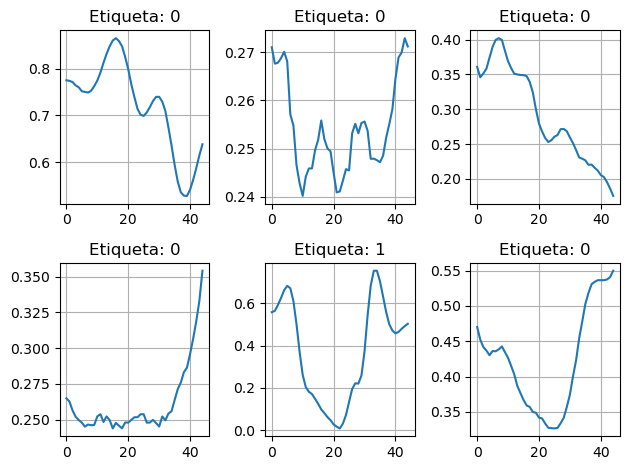

In [10]:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.grid()
    plt.title("Etiqueta: {}".format(train_labels[i]))
    plt.plot(train_signals[i])
    #plt.plot(train_signals[i])
plt.tight_layout()

In [11]:
def Model():
    """
    Fully Connected Layer
    """
    model = K.models.Sequential([
        K.layers.Flatten(),
        K.layers.Dense(32, input_dim=45, activation="relu"),
        K.layers.Dense(8, activation="relu"),
        K.layers.Dense(1, activation="linear"),
        K.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [12]:
### tf.random.set_seed(42)
q_model = Model()
checkpoint_path = "checkpoints/quantum.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

q_history = q_model.fit(
    train_signals,
    train_labels,
    validation_data=(valid_signals, valid_labels),
    batch_size=16,
    epochs=50,
    verbose=2,
    callbacks=[cp_callback]
)

Epoch 1/50
29/29 - 2s - loss: 0.6074 - accuracy: 0.9328 - val_loss: 0.5543 - val_accuracy: 0.9831 - 2s/epoch - 67ms/step
Epoch 2/50
29/29 - 0s - loss: 0.4794 - accuracy: 0.9935 - val_loss: 0.4137 - val_accuracy: 0.9831 - 379ms/epoch - 13ms/step
Epoch 3/50
29/29 - 0s - loss: 0.3259 - accuracy: 0.9957 - val_loss: 0.2634 - val_accuracy: 0.9831 - 412ms/epoch - 14ms/step
Epoch 4/50
29/29 - 0s - loss: 0.1999 - accuracy: 0.9957 - val_loss: 0.1596 - val_accuracy: 0.9831 - 376ms/epoch - 13ms/step
Epoch 5/50
29/29 - 0s - loss: 0.1249 - accuracy: 0.9957 - val_loss: 0.0984 - val_accuracy: 1.0000 - 395ms/epoch - 14ms/step
Epoch 6/50
29/29 - 0s - loss: 0.0848 - accuracy: 0.9957 - val_loss: 0.0680 - val_accuracy: 1.0000 - 328ms/epoch - 11ms/step
Epoch 7/50
29/29 - 0s - loss: 0.0642 - accuracy: 0.9957 - val_loss: 0.0504 - val_accuracy: 1.0000 - 329ms/epoch - 11ms/step
Epoch 8/50
29/29 - 0s - loss: 0.0506 - accuracy: 0.9957 - val_loss: 0.0424 - val_accuracy: 1.0000 - 324ms/epoch - 11ms/step
Epoch 9/50


In [13]:
q_model.save('hybridqcmodel.h5')

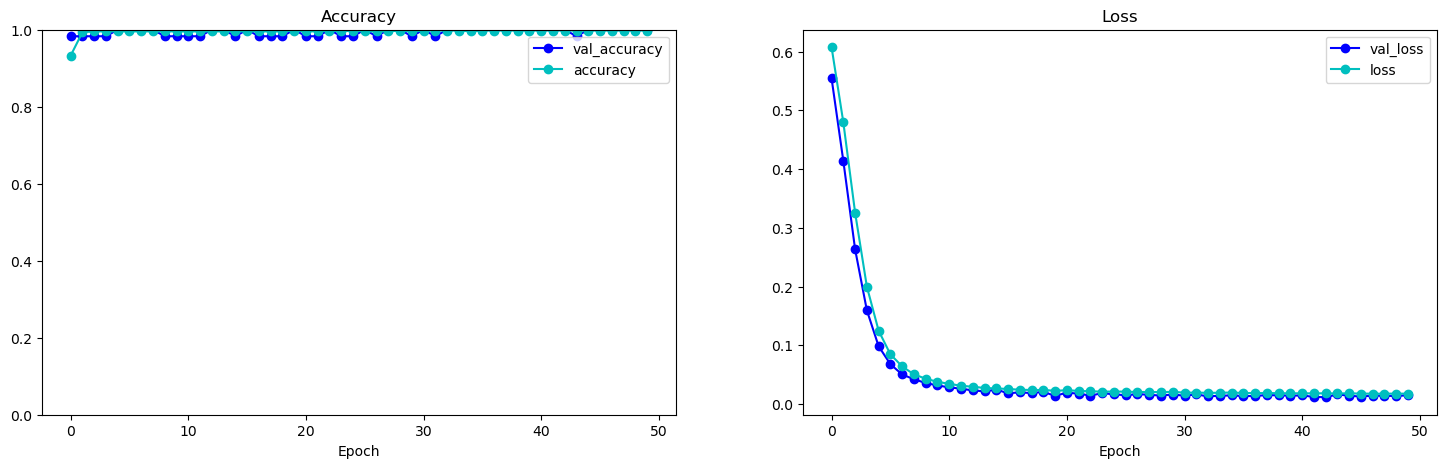

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.plot(q_history.history["val_accuracy"], "-ob", label="val_accuracy")
ax1.plot(q_history.history["accuracy"], "-oc", label="accuracy")
ax1.set_ylim([0, 1])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="val_loss")
ax2.plot(q_history.history["loss"], "-oc", label="loss")
ax2.set_title("Loss")
ax2.set_xlabel("Epoch")
ax2.legend()
plt.show()

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de confusión modelo híbrido convolución cuántica',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta Real')
    plt.xlabel('Etiqueta Predicha')
    plt.show()

In [13]:
# Get Saved Model
q_model = K.models.load_model('hybridqcmodel.h5')

In [14]:
yhat = q_model.predict(test_signals)
yhat = (yhat > 0.5).astype(int)

5/5 [==============================] - 0s 2ms/step


In [15]:
print(classification_report(test_labels, yhat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      1.00      1.00        66

    accuracy                           1.00       139
   macro avg       1.00      1.00      1.00       139
weighted avg       1.00      1.00      1.00       139



Confusion matrix, without normalization


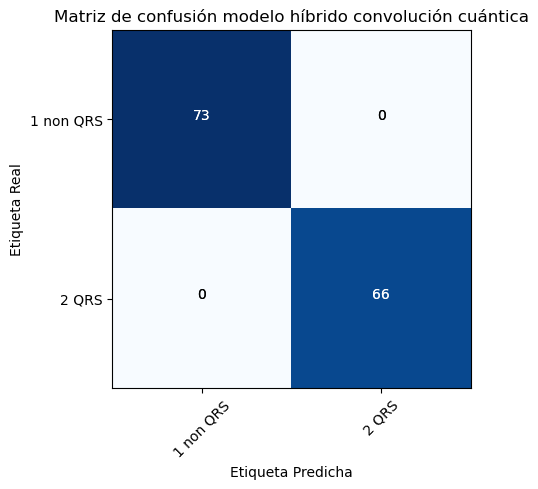

In [25]:
# Compute confusion matrix
cnf_matrix = tf.math.confusion_matrix(test_labels, yhat)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
#plt.figure(figsize=(6, 6))
plot_confusion_matrix(np.array(cnf_matrix), classes=['1 non QRS', '2 QRS'], normalize=False)